In [1]:
import torch
import numpy as np
from pathlib import Path
import logging
from torch.utils.data import DataLoader
from dataset import ViTacVisDataset
from torch.utils.tensorboard import SummaryWriter
import argparse
from torch import nn
import torch.nn.functional as F

In [2]:
# parser = argparse.ArgumentParser("Train model.")
# parser.add_argument("--epochs", type=int, help="Number of epochs.", required=True)
# parser.add_argument("--data_dir", type=str, help="Path to data.", required=True)
# parser.add_argument(
#     "--checkpoint_dir", type=str, help="Path for saving checkpoints.", required=True
# )

# parser.add_argument("--lr", type=float, help="Learning rate.", required=True)
# parser.add_argument(
#     "--sample_file", type=int, help="Sample number to train from.", required=True
# )
# parser.add_argument(
#     "--batch_size", type=int, help="Batch Size.", required=True
# )

In [3]:
class FLAGS():
    def __init__(self):
        self.data_dir = '/home/tasbolat/some_python_examples/data_VT_SNN/'
        self.batch_size = 8
        self.sample_file = 1
        self.lr = 0.01
        self.epochs = 2000
        self.output_size = 20
args = FLAGS()

In [4]:
device = torch.device("cuda:2")

In [5]:
train_dataset = ViTacVisDataset(
    path=args.data_dir, sample_file=f"train_80_20_{args.sample_file}.txt", output_size=args.output_size
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4
)
test_dataset = ViTacVisDataset(
    path=args.data_dir, sample_file=f"test_80_20_{args.sample_file}.txt", output_size=args.output_size
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4
)

In [6]:
# define NN models
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(5,5), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(5,5), stride=(1,1))

    def forward(self, x):
#         print('CNN input:', x.shape)
        x = self.conv1(x)
        # print('Conv', x.size()) 
        x = F.max_pool2d(x, 2)
        #print('Pool 1', x.size())
        x = F.relu(x)
        
        x = self.conv2(x)
        # print('Conv', x.size()) 
        x = F.max_pool2d(x, 2)
        #print('Pool 2', x.size())
        #x = F.relu(x)
        x = x.view(-1, 8*5*3)
        return x

In [7]:
class CNN_LSTM(nn.Module):

    def __init__(self):
        
        super(CNN_LSTM, self).__init__()
        self.input_size = 8*5*3
        self.hidden_dim = 32
        self.num_layers = 1
        
        self.cnn = CNN()

        # Define the LSTM layer
        self.gru = nn.GRU(self.input_size, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.fc = nn.Linear(self.hidden_dim, 20)
        
        #self.fc_mlp = nn.Linear(6300, self.input_size)

    def forward(self, x):
        
        #print('Model input ', x.size())
        batch_size, C, H, W, sequence_size = x.size()
        
        # create CNN embedding
        cnn_embed_seq = []
        for t in range(sequence_size):
            cnn_out = self.cnn(x[...,t])
            cnn_embed_seq.append(cnn_out)
        
        cnn_embed_seq = torch.stack(cnn_embed_seq, dim=0)
        #print('cnn_embed_seq: ', cnn_embed_seq.shape)
        
        # forward on GRU
        # (seq_len, batch, input_size)
        gru_out, hidden = self.gru(cnn_embed_seq)
        #print('gru out: ', gru_out.shape)
        
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.fc(gru_out[-1, :, :])
        
        #print(y_pred.shape)
        return y_pred

In [8]:
net = CNN_LSTM().to(device)
# Create snn loss instance.
criterion = nn.CrossEntropyLoss()
# Define optimizer module.
optimizer = torch.optim.RMSprop(
    net.parameters(), lr=0.0001)

In [9]:
train_accs = []
test_accs = []
train_loss = []
test_loss = []
for epoch in range(args.epochs):
    # Training loop.
    net.train()
    correct = 0
    batch_loss = 0
    train_acc = 0
    for i, (in_viz, _, label) in enumerate(train_loader, 0):

        in_viz = in_viz.to(device)
        label = label.to(device)
        # Forward pass of the network.
        #print(in_viz.shape)
        out = net.forward(in_viz)
        #print(out_tact.shape)
        # Calculate loss.
        #print(label.shape)
        loss = criterion(out, label)
        #print(loss)

        batch_loss += loss.cpu().data.item()
        # Reset gradients to zero.
        optimizer.zero_grad()
        # Backward pass of the network.
        loss.backward()
        # Update weights.
        optimizer.step()

        _, predicted = torch.max(out.data, 1)
        correct += (predicted == label).sum().item()

    # Reset training stats.
    train_acc = correct/len(train_loader.dataset)
    train_loss.append(batch_loss/len(train_loader.dataset))
    train_accs.append(train_acc)
    #print(train_acc, batch_loss)

    # testing
    net.eval()
    correct = 0
    batch_loss = 0
    test_acc = 0
    with torch.no_grad():
        for i, (in_viz, _, label) in enumerate(test_loader, 0):
            in_viz = in_viz.to(device)
            # Forward pass of the network.
            out = net.forward(in_viz)
            label = label.to(device)
            _, predicted = torch.max(out.data, 1)
            correct += (predicted == label).sum().item()
            # Calculate loss.
            loss = criterion(out, label)
            batch_loss += loss.cpu().data.item()

    test_loss.append(batch_loss/len(test_loader.dataset))
    test_acc = correct/len(test_loader.dataset)
    test_accs.append(test_acc)
    if epoch%10 == 0:
        print(epoch, 'Train:', train_acc, 'Test:', test_acc)

0 Train: 0.06666666666666667 Test: 0.08333333333333333
10 Train: 0.1625 Test: 0.06666666666666667
20 Train: 0.1875 Test: 0.13333333333333333
30 Train: 0.2375 Test: 0.11666666666666667
40 Train: 0.30416666666666664 Test: 0.11666666666666667
50 Train: 0.3416666666666667 Test: 0.13333333333333333
60 Train: 0.4125 Test: 0.16666666666666666
70 Train: 0.45416666666666666 Test: 0.11666666666666667
80 Train: 0.5166666666666667 Test: 0.15
90 Train: 0.5416666666666666 Test: 0.13333333333333333
100 Train: 0.5625 Test: 0.13333333333333333
110 Train: 0.6125 Test: 0.18333333333333332
120 Train: 0.6333333333333333 Test: 0.18333333333333332
130 Train: 0.65 Test: 0.2
140 Train: 0.675 Test: 0.18333333333333332
150 Train: 0.7 Test: 0.18333333333333332
160 Train: 0.7208333333333333 Test: 0.2
170 Train: 0.7458333333333333 Test: 0.18333333333333332
180 Train: 0.775 Test: 0.16666666666666666
190 Train: 0.7833333333333333 Test: 0.16666666666666666
200 Train: 0.8 Test: 0.16666666666666666
210 Train: 0.81666666

2030 Train: 1.0 Test: 0.13333333333333333
2040 Train: 1.0 Test: 0.13333333333333333
2050 Train: 1.0 Test: 0.15
2060 Train: 1.0 Test: 0.13333333333333333
2070 Train: 1.0 Test: 0.13333333333333333
2080 Train: 1.0 Test: 0.13333333333333333
2090 Train: 1.0 Test: 0.13333333333333333
2100 Train: 1.0 Test: 0.13333333333333333
2110 Train: 1.0 Test: 0.13333333333333333
2120 Train: 1.0 Test: 0.13333333333333333
2130 Train: 1.0 Test: 0.13333333333333333
2140 Train: 1.0 Test: 0.13333333333333333
2150 Train: 1.0 Test: 0.13333333333333333
2160 Train: 1.0 Test: 0.13333333333333333
2170 Train: 1.0 Test: 0.13333333333333333
2180 Train: 1.0 Test: 0.13333333333333333
2190 Train: 1.0 Test: 0.13333333333333333
2200 Train: 1.0 Test: 0.13333333333333333
2210 Train: 1.0 Test: 0.13333333333333333
2220 Train: 1.0 Test: 0.13333333333333333
2230 Train: 1.0 Test: 0.13333333333333333
2240 Train: 1.0 Test: 0.13333333333333333
2250 Train: 1.0 Test: 0.13333333333333333
2260 Train: 1.0 Test: 0.13333333333333333
2270 Tr

4180 Train: 1.0 Test: 0.13333333333333333
4190 Train: 1.0 Test: 0.13333333333333333
4200 Train: 1.0 Test: 0.13333333333333333
4210 Train: 1.0 Test: 0.15
4220 Train: 1.0 Test: 0.15
4230 Train: 1.0 Test: 0.13333333333333333
4240 Train: 1.0 Test: 0.15
4250 Train: 1.0 Test: 0.15
4260 Train: 1.0 Test: 0.15
4270 Train: 1.0 Test: 0.15
4280 Train: 1.0 Test: 0.15
4300 Train: 1.0 Test: 0.15
4310 Train: 1.0 Test: 0.15
4320 Train: 1.0 Test: 0.15
4330 Train: 1.0 Test: 0.13333333333333333
4340 Train: 1.0 Test: 0.15
4350 Train: 1.0 Test: 0.13333333333333333
4360 Train: 1.0 Test: 0.13333333333333333
4370 Train: 1.0 Test: 0.13333333333333333
4380 Train: 1.0 Test: 0.13333333333333333
4390 Train: 1.0 Test: 0.13333333333333333
4400 Train: 1.0 Test: 0.13333333333333333
4410 Train: 1.0 Test: 0.13333333333333333
4420 Train: 1.0 Test: 0.13333333333333333
4430 Train: 1.0 Test: 0.13333333333333333
4440 Train: 1.0 Test: 0.15
4450 Train: 1.0 Test: 0.15
4460 Train: 1.0 Test: 0.15
4470 Train: 1.0 Test: 0.15
4480 Tr

6520 Train: 1.0 Test: 0.13333333333333333
6530 Train: 1.0 Test: 0.13333333333333333
6540 Train: 1.0 Test: 0.13333333333333333
6550 Train: 1.0 Test: 0.13333333333333333
6560 Train: 1.0 Test: 0.13333333333333333
6570 Train: 1.0 Test: 0.13333333333333333
6580 Train: 1.0 Test: 0.13333333333333333
6590 Train: 1.0 Test: 0.13333333333333333
6600 Train: 1.0 Test: 0.13333333333333333
6610 Train: 1.0 Test: 0.15
6620 Train: 1.0 Test: 0.13333333333333333
6630 Train: 1.0 Test: 0.15
6640 Train: 1.0 Test: 0.15
6650 Train: 1.0 Test: 0.15
6660 Train: 1.0 Test: 0.15
6680 Train: 1.0 Test: 0.15
6690 Train: 1.0 Test: 0.15
6700 Train: 1.0 Test: 0.15
6710 Train: 1.0 Test: 0.16666666666666666
6720 Train: 1.0 Test: 0.16666666666666666
6730 Train: 1.0 Test: 0.18333333333333332
6740 Train: 1.0 Test: 0.18333333333333332
6750 Train: 1.0 Test: 0.18333333333333332
6760 Train: 1.0 Test: 0.16666666666666666
6770 Train: 1.0 Test: 0.16666666666666666
6780 Train: 1.0 Test: 0.15
6790 Train: 1.0 Test: 0.15
6800 Train: 1.0 

KeyboardInterrupt: 

In [10]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [11]:
params

16456

In [12]:
import matplotlib.pyplot as plt

In [13]:
np.max(test_accs)

0.21666666666666667

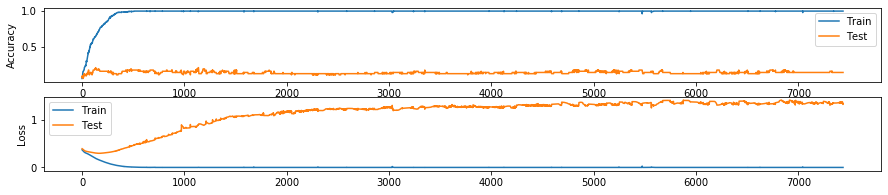

In [15]:
fig, ax = plt.subplots(2, figsize=(15,3))
ax[0].plot(train_accs)
ax[0].plot(test_accs)
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Test'])

ax[1].plot(train_loss)
ax[1].plot(test_loss)
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Test'])

plt.show()